#### In this notebook the BOA code in Python is implemented.

We also tested the implementation of the algorithm on different configurations of dummy matrices, in order to gain a better understanding of the physical meaning of the results.

In [1]:
#Import libraries

import numpy as np
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft, ifft, rfft, fft2, ifft2
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.ndimage import rotate

plt.rcParams["figure.figsize"] = 12, 10
%matplotlib inline

## Functions for the application of the Belkin O'Reilly Algorithm (BOA)

In [2]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    Finds maximum of a 5x5 sliding window. If the central pixel is the maximum, this is flagged as a one.
    All other pixels are flagged as zero.
    """
    
    nodatidx = ingrid.flatten()*np.nan # creates single dim array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)   # outgrid is a matrix with the shape of ingrid, full of Zeros

    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)] # return the last 5 rows of the last 5 columns of the matrix
            if np.isnan(subg).sum()==25:    #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    # array with values of the transpose subg matrix
                ma = np.argmax(subg.flatten())      # index with the maximum value of subg array
               
                mi = np.argmin(subg.flatten())      # index with the minimum value of subg array
                
                
                if ma==12 or mi==12:                 #if ma or mi is the middle value of the 5X5 matrix
                    outgrid[i-1,j-1] = 1             #flagged as 1
                else:
                    outgrid[i-1,j-1] = 0             #all other pixels are flagged as 0
    
    return outgrid

In [3]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    Returns a median smoothed grid of satellite data
    """
    
    outgrid = ingrid*0   # matrix of 0s with shape of ingrid matrix

    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]      # submatrix subg (3x3) 
                if np.isnan(subg).sum()==9:                  # if all values in submatrix subg (3x3) are null values:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()         # array with values of the transpose subg matrix
                    ma = np.argmax(subg.flatten())           # index with the maximum value of subg array
                    mi = np.argmin(subg.flatten())           # index with the minimum value of subg array
                    
                    if (ma==4 or mi==4):                      #if ma or mi is the middle value of the 3X3 matrix
                        outgrid[i-1,j-1] = nanmedian(subg)    # median while ignoring NaNs.
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [4]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        """
        Workhorse filter from EBImage. Modified so we don't need colorspace and other annoying requirements ????
        """
        
        dx = x.shape                          
        df = filt.shape  
        
        if (df[0]//2 == 0) or (df[1]//2 == 0):
            sys.exit('dimensions of "filter" matrix must be odd')
        if (dx[0] < df[0]) or (dx[1] < df[1]):
            sys.exit("dimensions of 'x' must be bigger than 'filter'")
            
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)       #matrix with zeros with shape of x

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    #put values of filt in the middle of matrix wf

        wf = fft2(wf)         #apply the 2 dimensional discrete fourier transform                  
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1   

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1   
        #these index will be used to reorder values of matrix y
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])        #filter in x
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])        #filter in y
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999) ##replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)        #matriz with the dimensions of grid35 (True if value is nan, False otherwise)
    # convert these (True values of naidx) to zeros (in grid35) for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))    
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))   
    front = np.sqrt((tx**2)+(ty**2))                   #front is square root of the sum of the squares of tx and ty


#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    #using size because lon and lat are matrices
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply a sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')

    matrix_front =  mask * np.flip(front.T, 0)   #matrix of mask raster file * matrix of ssr raster file


    
    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size             #nr of elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)     #matrix of zeros with shape of ingrid matrix

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi    # change radians to degrees

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])    #Adjust to 0-360 scheme (make negative degrees positive)
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360     #Convert degrees so that 0 degrees is North and East is 90 degrees
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask

        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

#### In R code raster files are often used to store and access data features from generated matrices, but in order to reduce runtime and code complexity, when I converted to Python I made some changes so that it is not necessary to use these raster files


### Interpretation of values obtained through BOA algorithm

Below we will test different configurations of dummy matrices, to which the BOA algorithm will be applied, in order to gain a better understanding of the physical meaning of the results obtained

In [408]:
test = np.ones((100,100))     
test[:, 20:21] = 9
#test[:, 15:16] = 9
#test[50:51, :10] = 9
#test[60:61, :] = 9
#Dummy matrix de 1s mas com uma linha vertical de 9s

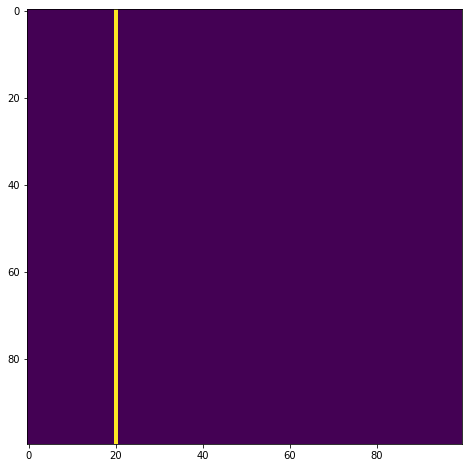

In [409]:
plt.imshow(test)

In [410]:

# matrices longitude and latitude needed to apply function BOA
lon2 = np.arange(100)
lat2 = np.arange(100)

In [411]:
front_dummy = boa(lon=lon2, lat=lat2, ingrid=test, nodata = np.nan, direction = False)

In [412]:
front_dummy = np.flip(front_dummy, axis=0)
front_dummy = np.array([[front_dummy[j][i] for j in range(len(front_dummy))] for i in range(len(front_dummy[0])-1,-1,-1)])


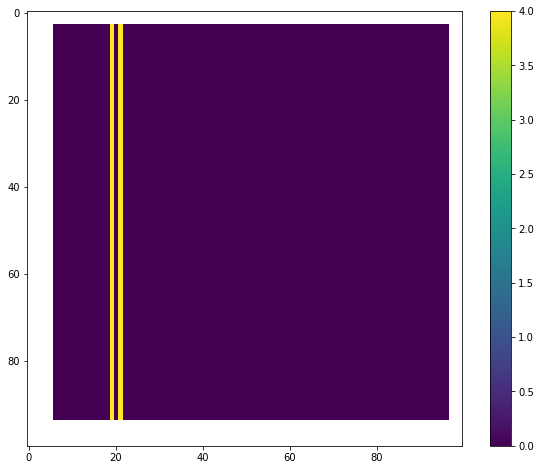

In [413]:
plt.imshow(front_dummy)
plt.colorbar()

#### Conclusion:

As we can see, applying the BOA to the dummy matrix returns two "fronts" whose value is 4. Now, since the difference between the pixel values was 8 (9-1), then the values returned by the BOA are half of the "original temperature difference".

In [422]:
test2 = np.ones((30,30))
#test2[5,5] = 10
np.fill_diagonal(test2, 5)
test2[[0,1,2,3,4,5,6],[0,1,2,3,4,5,6]] = 1

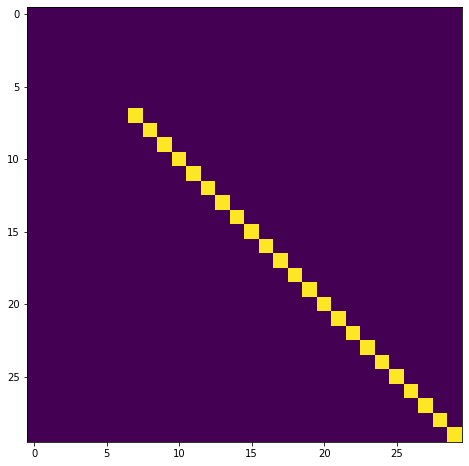

In [423]:
plt.imshow(test2)

In [424]:

lon3 = np.arange(30)
lat3 = np.arange(30)

In [425]:
front_dummy2 = boa(lon=lon3, lat=lat3, ingrid=test2, nodata = np.nan, direction = True)

In [426]:
front_dummy2 = np.flip(front_dummy2, axis=0)
front_dummy2 = np.array([[front_dummy2[j][i] for j in range(len(front_dummy2))] for i in range(len(front_dummy2[0])-1,-1,-1)])


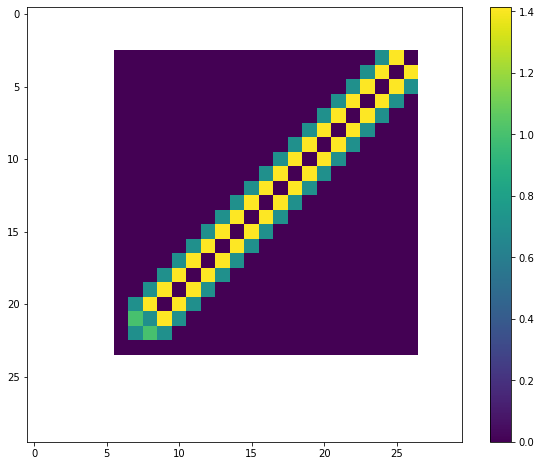

In [427]:
plt.imshow(front_dummy2)
plt.colorbar()

In [568]:
test = np.ones((100,100))

#these variables define the horizontal and vertical limits of the inner square
h1 = int(test.shape[0]/2-20)
h2 = int(test.shape[0]/2+20)
v1 = int(test.shape[1]/2-20)
v2 = int(test.shape[1]/2+20)

test[h1:h2, v1:v2] = 5    #create a square with the limits established above

#test[int(test.shape[0]/2):int(test.shape[0]/2+20), int(test.shape[1]/2-20):int(test.shape[1]/2+20)] = 5

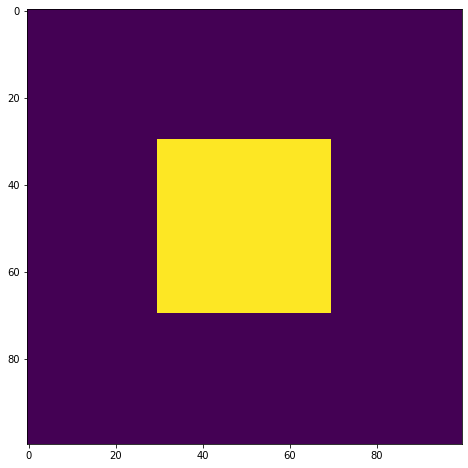

In [569]:
plt.imshow(test);

In [570]:
#variables to define the diagonal that crosses the matrix square
d1 = list(range(h1, v2))
d2 = list(range(h1, v2))

In [571]:
test[d1, d2] = 20

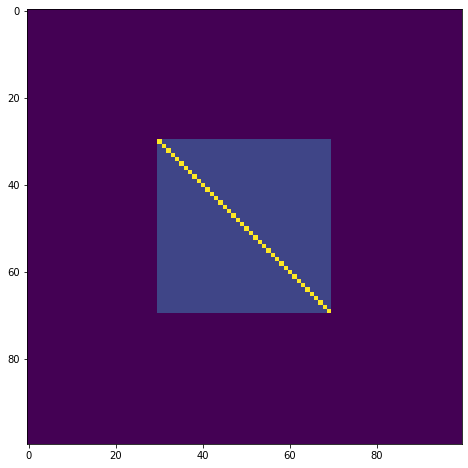

In [572]:
plt.imshow(test);

In [573]:
new_d1 = np.arange(h1,v2-10)
new_d2 = np.arange(h1+10, v2)

In [574]:
test[new_d1, new_d2] = 40

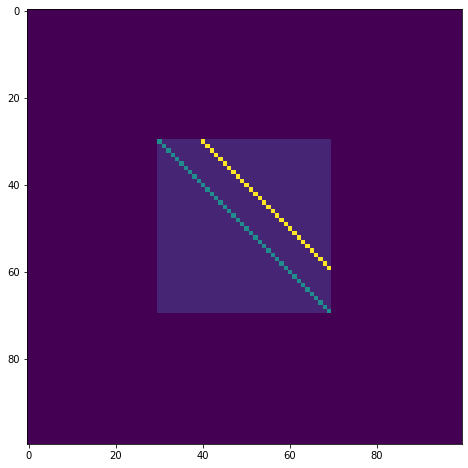

In [575]:
plt.imshow(test)

In [576]:
new2_d1 = np.arange(h1,v2-20)
new2_d2 = np.arange(h1+20, v2)

In [577]:
test[new2_d1, new2_d2] = 60

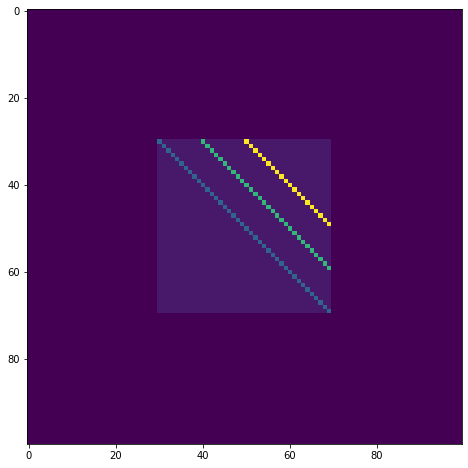

In [578]:
plt.imshow(test)

In [579]:
lon2 = np.arange(100)
lat2 = np.arange(100)


In [580]:
front2 = boa(lon=lon2, lat=lat2, ingrid=test, nodata = np.nan, direction = False)

In [583]:
#front2 = np.flip(front2, axis=0)
front2 = np.array([[front2[j][i] for j in range(len(front2))] for i in range(len(front2[0])-1,-1,-1)])
front2


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

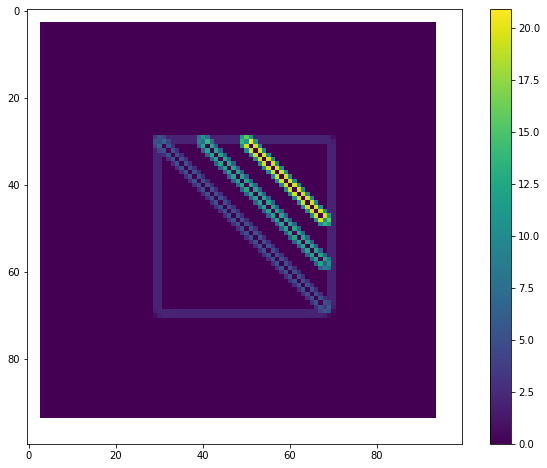

In [584]:
plt.imshow(front2)
plt.colorbar()

In [590]:
test3 = np.ones((100,100))

In [591]:
hor1 = 0
hor2 = int(test.shape[0])
vert1 = 0
vert2 = int(test.shape[1])

In [592]:
test3[:, int(hor2/2)] = 5

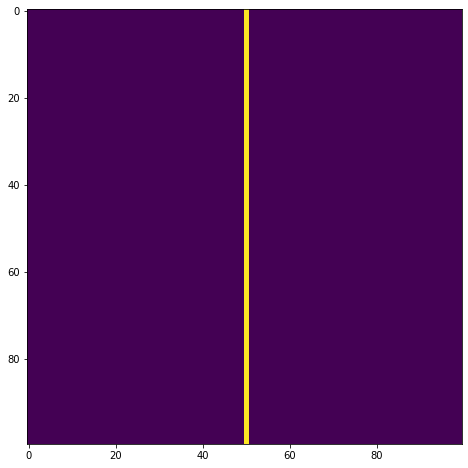

In [593]:
plt.imshow(test3)

In [594]:
test3[:, int(hor2/2):] = 5
test3[:, int(hor2/2*1.5):] = 10
test3[:, int(hor2/2*1.5)] = 1

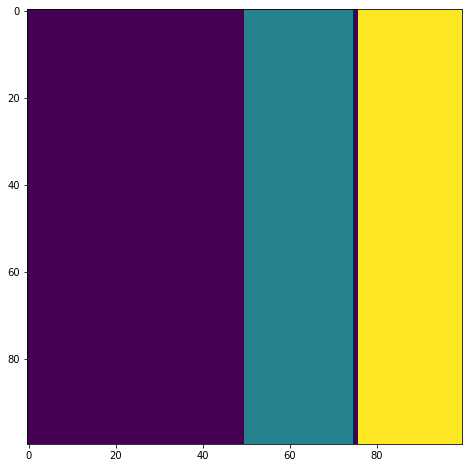

In [595]:
plt.imshow(test3)

In [596]:
test3

array([[ 1.,  1.,  1., ..., 10., 10., 10.],
       [ 1.,  1.,  1., ..., 10., 10., 10.],
       [ 1.,  1.,  1., ..., 10., 10., 10.],
       ...,
       [ 1.,  1.,  1., ..., 10., 10., 10.],
       [ 1.,  1.,  1., ..., 10., 10., 10.],
       [ 1.,  1.,  1., ..., 10., 10., 10.]])

In [599]:
x = rotate(test3, angle=45, reshape=False).astype('float')

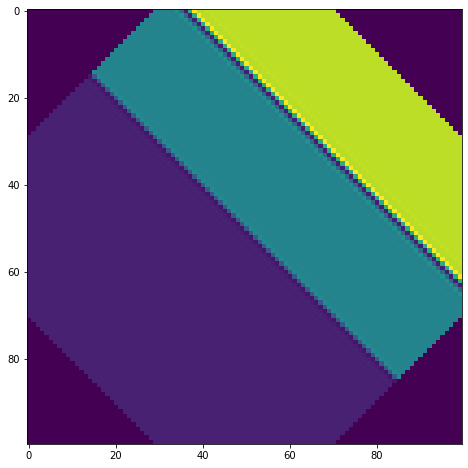

In [600]:
plt.imshow(x)

In [580]:
lon3 = np.arange(141)
lat3 = np.arange(141)

In [581]:
front3 = boa(lon=lon3, lat=lat3, ingrid=x, nodata = np.nan, direction = False)

In [582]:
#front3 = np.flip(front3, axis=0)
front3 = np.array([[front3[j][i] for j in range(len(front3))] for i in range(len(front3[0])-1,-1,-1)])

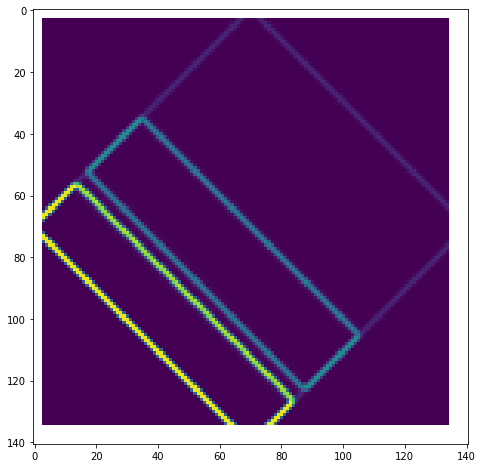

In [583]:
plt.imshow(front3)

In [630]:
y = np.rot90(test3, k=1, axes=(0,1))

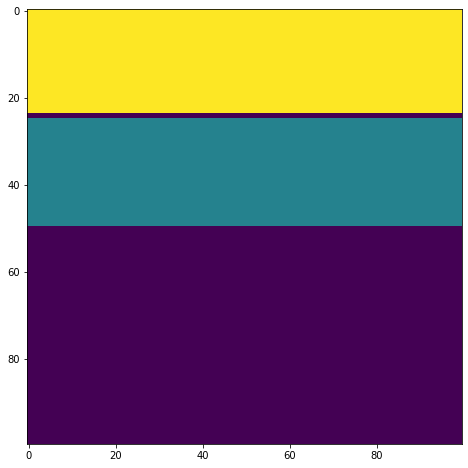

In [631]:
plt.imshow(y)

In [632]:
lon4 = np.arange(100)
lat4 = np.arange(100)

In [633]:
front4 = boa(lon=lon4, lat=lat4, ingrid=y, nodata = np.nan, direction = False)

In [640]:
front4 = np.flip(front4, axis=0)
#front4 = np.array([[front4[j][i] for j in range(len(front4))] for i in range(len(front4[0])-1,-1,-1)])

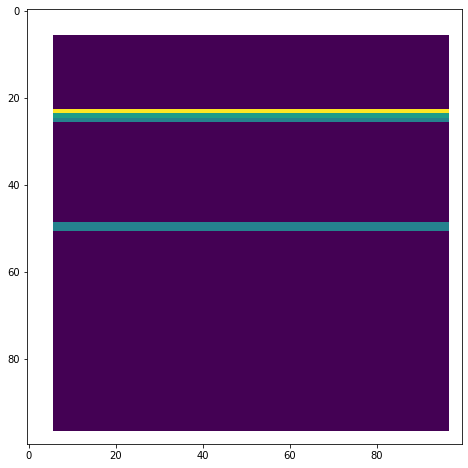

In [642]:
plt.imshow(front4)

In [744]:
test4 = np.ones((80,80))
a = np.tile(5, (40,40))
a[int(a.shape[0]/4):int(a.shape[0]/2), :] = 10
a[int(a.shape[0]/2):int(a.shape[0]*3/4), :] = 20
a[int(a.shape[0]*3/4):, :] = 30
#a[int(a.shape[0]/2):a.shape[0], :] = 0

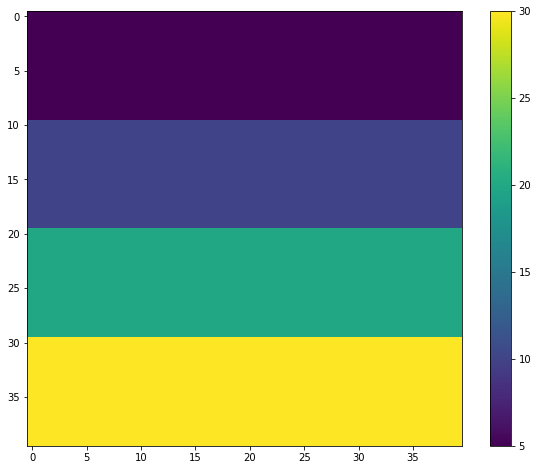

In [745]:
plt.imshow(a)
plt.colorbar()

In [746]:
b = rotate(a, angle=45, reshape=True).astype('float')

b = np.where(b == 0, 1, b)

In [747]:
b[int(b.shape[0]/2):, :] = 1

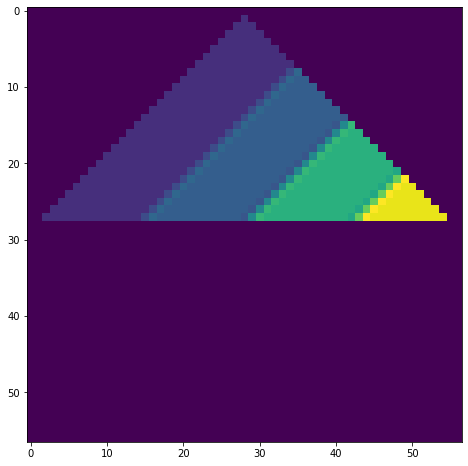

In [748]:
plt.imshow(b)

In [749]:
test4[int(test4.shape[0]/2-b.shape[0]/2):int(test4.shape[0]/2+b.shape[0]/2), int(test4.shape[1]/2-b.shape[0]/2):int(test4.shape[0]/2+b.shape[0]/2)] = b

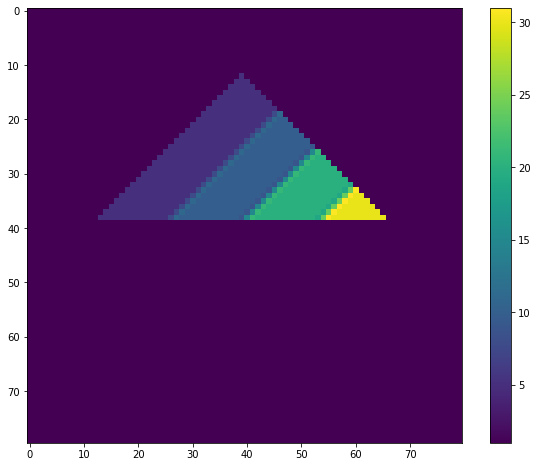

In [750]:
plt.imshow(test4)
plt.colorbar()

In [751]:
lon5 = np.arange(80)
lat5 = np.arange(80)

In [752]:
front5 = boa(lon=lon5, lat=lat5, ingrid=test4, nodata = np.nan, direction = False)

In [757]:
#front5 = np.flip(front5, axis=0)
front5 = np.array([[front5[j][i] for j in range(len(front5))] for i in range(len(front5[0])-1,-1,-1)])

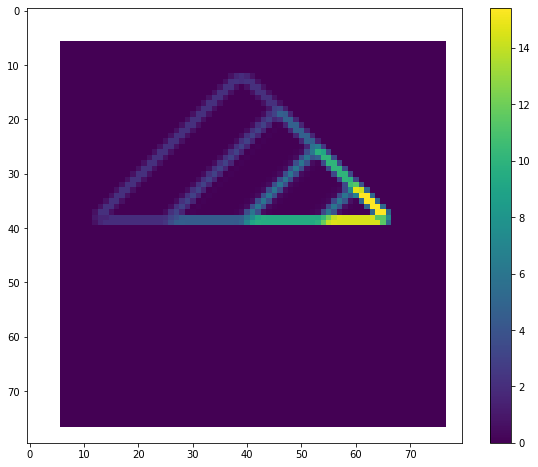

In [758]:
plt.imshow(front5)
plt.colorbar()

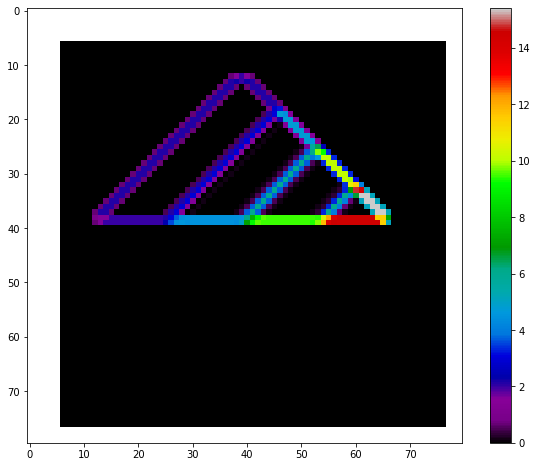

In [761]:
imgplot = plt.imshow(front5)
imgplot.set_cmap('nipy_spectral')
plt.colorbar()